<a href="https://colab.research.google.com/github/melissamelton/BachelorAnalysis/blob/main/TheBachelorAnalysis_GSB521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Bachelor Analysis- funny name here**


*By Melissa Melton (mnmelton@calpoly.edu) & Annika Bertelsen (abertels@calpoly.edu)*

February 22, 2023

**Breif Background**: A single bachelor (or bachelorette) dates a group of approximaetly 30 women (or men) over several weeks, narrowing the group of contestants down week by week after a series of one-on-one or group dates to hopefully find true love.

Our goal of this Bachelor and Bachelorette themed data analysis is to gather historical data of all participating contestants from recent seasons, to be able to identify any trends within contestant demographics or number of dates attended.
Focusing on the Winner of each season, as well as contestants who made it to the Top Four, we will utilize demographics such as age, occupation, home state, and race? to perform statistical analysis on how much each feature contributes to contestants success likelihood.

**Hypothesis:** One of our driving questions for this analysis was: What is the average number of dates until a proposal across the Bachelor and Bachelorette?
Our hypothesis is that the average number of dates will play a vital role in the success likelyhood. We believe that the winning contestants will have attended more dates than competitors, {and furthermore that the number of dates will be a stronger indicator variable to success for the Bachelorette vs the Bachelor because of our preconcieved notion that women may value quality time (greater average number of dates before proposal} more then men. 
Our second driving question was which variables from contestant demographics will be the most important in predicting the outcome? Here, we hypothesize that age will be the most significant predictor for the Bachelor, while occupation will be the most significant for the Bachelorette. This hypothesis is rooted in sterotypes that men may tend to go for the younger woman while women may put high value on suitors occupations.

In [119]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as  image
import seaborn as sns

# The Bachelor Data Gathering & Cleaning

We will start by gathering data on contestants from the Bachelor.

## Scraping

Obtain a list of the seasons we can scrape data from on Wikipedia:

In [297]:
# The Bachelor has had 26 seasons so far (27 is currently airing so it will not be included)
seasons = np.arange(1, 27, 1)
# seasons 3, 4, and 6-8 do not have contestant data on Wikipedia
missing_table = {3, 4, 6, 7, 8}
# obtain list of season numbers which have contestant data on their wiki page
seasons = [x for x in seasons if x not in missing_table]

We will now use the BeautifulSoup library to scrape data about contestants from Wikipedia.

In [298]:
contestants_df = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelor_(American_season_"

def seasons_scrape(seasons, contestants_df, urlstart):
  # loop through seasons
  for i in range(0, len(seasons)):
    # write the url for specific season
    wikiurl = urlstart + str(seasons[i]) + ")"
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(wikiurl)
    # parse data from html
    soup = BeautifulSoup(response.text, 'html.parser')
    contestant_table = soup.find('table', {'class':"wikitable"})
    df = pd.read_html(str(contestant_table))
    # convert list to dataframe
    df = pd.DataFrame(df[0])
    # add column for the season (value the same for all rows from that season)
    df['Season'] = seasons[i]
    # seasons 1 and 2 have a different label for the Outcome and Occupation columns
    if 'Eliminated' in df.columns and 'Job' in df.columns:
      df.rename(columns = {'Eliminated': 'Outcome',
                           'Job': 'Occupation'}, inplace = True)
    # keep only desired columns
    df = df[['Season', 'Name', 'Age', 'Hometown', 'Occupation', 'Outcome']]
    contestants_df = contestants_df.append(df, ignore_index = True)
  return contestants_df


In [299]:
contestants_df = seasons_scrape(seasons, contestants_df, urlstart)

Unfortunately, full contestant data cannot be found online for seasons 3, 4, 6, 7, and 8 (even the Bachelor Nation fandom Wiki does not have it). So, our resulting dataframe only represents 21 of the 26 full seasons.

## Cleaning

Perform clean-up on the contestants_df dataframe.

In [300]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df[contestants_df['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df = contestants_df[contestants_df['Age'] != "(Returned to competition)"]

In [301]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df['Name'] = contestants_df['Name'].apply(lambda x: x.split('[')[0]
                                                      if '[' in x else x)
# separate town and state into their own columns
contestants_df[['Town', 'State']] = contestants_df.Hometown.str.split(',', expand = True)
# make sure age is numeric
contestants_df['Age'] = pd.to_numeric(contestants_df['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df = contestants_df[cols]

In [302]:
contestants_df

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Amanda Marsh,23.0,Chanute,Kansas,Event Planner,Winner
1,1,Trista Rehn,29.0,St. Louis,Missouri,Miami Heat Dancer,Runner-up
2,1,Shannon Oliver,24.0,Dallas,Texas,Financial Management Consultant,Week 5
3,1,Kim,24.0,Tempe,Arizona,Nanny,Week 4
4,1,Cathy Grimes,22.0,Terre Haute,Indiana,Graduate Student,Week 3
...,...,...,...,...,...,...,...
578,26,Jane Paik,33.0,Santa Monica,California,Social Media Director,Week 1
579,26,Lindsay Dobbs,27.0,Warner Robins,Georgia,Neonatal Nurse,Week 1
580,26,Rianna Hockaday,26.0,Mount Pleasant,Texas,Registered Nurse,Week 1
581,26,Samantha Jeffries,26.0,Dayton,Ohio,Occupational Therapist,Week 1


Create a new data frame representing all winners of the show. Note: Season 11 notoriously does not have a winner--that season's bachelor Brad Womack infamously broke up with both his final two women!

Create another new data frame with the top four contestants from each season.

In [303]:
# winners
winners_df = contestants_df[contestants_df['Outcome'] == "Winner"]

# top 4
top4_df = contestants_df.groupby('Season').head(4)

## Occupation Categorization 
The contestant occupations are specific to the individual. To better analyze trends in popular occupations, we will create a dictionary to categorize contestants' jobs. We created this dictionary based on common themes identified in the jobs of contestants in the top 4 of each season.

In [304]:
# set up key words we will use for detecting occupation categories
marketing = ['Marketing', 'Content', 'Publicist', 'Communications', 'Social Media']
sales = ['Sales', 'Salesperson']
managmentconsult = ['Consultant','Contractor', 'Business', 'Buyer']
teacher = ['Teacher']
student = ['Student']
medical = ['Nurse', 'Hospital', 'Chiropractic']
dance = ['Dancer', 'Dance Instructor', 'Cheerleader']
therapy = ['Psychologist', 'Therapist', 'Speech Pathologist']
dental = ['Dental']
realestate = ['Real Estate', 'Realtor']
attorney = ['Attorney']
flight = ['Flight']
arts = ['Graphic Designer', 'Creative Director', 'Photographer', 'Videographer', 'Actress', 'Designer']
beauty = ['Stylist', 'Hairstylist', 'Esthetician']
events = ['Event Planner', 'Bridal']
model = ['Model']

# create a dictionary of job categories, with the values representing the list of jobs within the key
job_dictionary1 = {'Marketing': marketing, 'Sales': sales, 'Teaching': teacher, 'Management and Consulting': managmentconsult,
                  'Medical': medical, 'Dance': dance, 'Therapy': therapy,
                  'Dental Care': dental, 'Real Estate': realestate, 'Legal': attorney, 
                  'Flight': flight, 'Arts': arts, 'Beauty': beauty, 
                  'Events': events, 'Modeling': model, 'Student': student}

Create a new column in the top4_df and winners_df data frames to input the job category of each contestant.

In [305]:
top4_df.insert(7, 'Female Job Category', '')
winners_df.insert(7, 'Female Job Category', '')

This function will look at the occupation of each contestant in a data frame and then look through each key, value pair in the provided job dictionary. If the contestant's occupation matches a job in one of the keys, the name of that key will be inputted as their job category. If the contestant's job does not appear in the dictionary, the category will be designated as "Other".

Note: we are only running this function for the top 4 and winners dataframes since these contestants' jobs were the ones used in designing the dictionary.

In [306]:
def detect_category(jobdict, df):
  # loop through all contestants in df
  for i in range(0, len(df)):
    contestant_job = df.iloc[i, 5]
    # look through each key, value pair in the dictionary
    for key, value in jobdict.items():
      for job in value:
        # compare each word in the category to the contestant's listed occupation
        if job.casefold() not in contestant_job.casefold():
          continue
        else:
          # if there is a match, set the category variable equal to the current category
          df.iloc[i,7] = key
    # if no matches detected, set category to 'Other'
    if df.iloc[i, 7] not in jobdict:
      df.iloc[i,7] = 'Other'
  return df

# run for top 4 and winners data frames
top4_df = detect_category(job_dictionary1, top4_df)
winners_df = detect_category(job_dictionary1, winners_df)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [307]:
top4_df

,Season,Name,Age,Town,State,Occupation,Outcome,Female Job Category
0,1,Amanda Marsh,23.0,Chanute,Kansas,Event Planner,Winner,Events
1,1,Trista Rehn,29.0,St. Louis,Missouri,Miami Heat Dancer,Runner-up,Dance
2,1,Shannon Oliver,24.0,Dallas,Texas,Financial Management Consultant,Week 5,Management and Consulting
3,1,Kim,24.0,Tempe,Arizona,Nanny,Week 4,Other
25,2,Helene Eksterowicz,27.0,Gloucester,New Jersey,School Psychologist,Winner,Therapy
...,...,...,...,...,...,...,...,...
518,25,Serena Pitt,23.0,Markham,Ontario,Publicist,Week 8,Marketing
552,26,Susie Evans,28.0,Poquoson,Virginia,Wedding Videographer,Winner,Arts
553,26,"Gabriela ""Gabby"" Windey",30.0,O'Fallon,Illinois,ICU Nurse,Runner-Up(Week 10),Medical
554,26,Rachel Recchia,25.0,Clermont,Florida,Flight Instructor,Runner-Up(Week 10),Flight


# The Bachelorette Data Gathering & Cleaning

Now we will perform the same process, but for contestants on the Bachelorette, where a female lead dates a group of male suitors.

## Scraping

Once again, we create an array representing the seasons we can obtain data from on Wikipedia. Thankfully this time, all seasons have contestant data available.

In [308]:
# The Bachelorette has had 19 seasons so far
seasons = np.arange(1, 20, 1)

Use the BeautifulSoup library to create a data frame containing information on all Bachelorette contestants, using the seasons_scrape() function from the prior section.

In [309]:
# create new contestant data frame for Bachelorette
contestants_df2 = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelorette_(American_season_"

# call seasons_scrape() function
contestants_df2 = seasons_scrape(seasons, contestants_df2, urlstart)

## Cleaning

Perform some clean-up on the contestants dataframe:

In [310]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df2[contestants_df2['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df2 = contestants_df2[contestants_df2['Age'] != "(Returned to competition)"]

contestants_df2 = contestants_df2.dropna(axis=0)

In [311]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df2['Name'] = contestants_df2['Name'].apply(lambda x: x.split('[')[0] if '[' in x else x)
# fix some unclean age values
contestants_df2['Age'] = contestants_df2['Age'].apply(str).apply(lambda x: x.split('[')[0] if '[' in x else x)
# separate town and state into their own columns
contestants_df2[['Town', 'State']] = contestants_df2['Hometown'].str.split(',', expand = True)
# make sure age is numeric
contestants_df2['Age'] = pd.to_numeric(contestants_df2['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df2 = contestants_df2[cols]

In [312]:
contestants_df2

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Ryan Sutter,28,Vail,Colorado,Firefighter,Winner
1,1,Charlie Maher,28,Hermosa Beach,California,Financial Analyst,Runner-up
2,1,Russell Woods,31,San Rafael,California,Writer,Week 5
3,1,Greg Todtman,28,Manhattan,New York,Importer,Week 4
4,1,Bob Guiney,31,Ferndale,Michigan,Mortgage Broker,Week 3
...,...,...,...,...,...,...,...
525,19,Chris Austin,30,Redondo Beach,California,Mentality Coach,Week 2
526,19,Jordan Vandergriff,27,Alpharetta,Georgia,Drag Racer,Week 2
527,19,Joey Young,24,Brookfield,Connecticut,Twin,Week 1
528,19,Justin Young,24,Brookfield,Connecticut,Other Twin,Week 1


Create two new data frames for the winners and top 4 of each season:

In [313]:
# winners
winners_df2 = contestants_df2[contestants_df2['Outcome'] == "Winner"]

# top 4
top4_df2 = contestants_df2.groupby('Season').head(4)

## Occupation Categorization

We will create a different jobs dictionary, since the male contestants tend to have different jobs from the female contestants. Like we did with the female contestants, we observed common trends among the top 4 contestants from each season to create this dictionary.

In [314]:
# set up key words we will use for detecting occupation categories
marketing = ['Marketing', 'Content', 'Publicist', 'Communications', 'Social Media']
finance = ['Banker', 'Portfolio', 'Equity', 'Financial', 'Investment']
sales = ['Sales', 'Salesperson', 'Salesman', 'Insurance Agent']
managementconsult = ['Consultant','Contractor', 'Business', 'Buyer', 'Entrepreneur', 'Wine', 'Restaurant', 'Startup', 'Account Executive', 'Tech Executive']
teacher = ['Teacher']
student = ['Student']
medical = ['Nurse', 'Hospital', 'Chiropractor', 'Medicine']
arts = ['Singer', 'Photographer', 'Writer', 'Musician', 'Art']
sports = ['Snowboarder', 'Football', 'Quarterback', 'Swimmer',' Trainer', 'Race', 'Baseball', 'Basketball', 'Personal Trainer']
therapy = ['Psychologist', 'Therapist', 'Speech Pathologist']
dental = ['Dental']
realestate = ['Real Estate', 'Realtor', 'Mortgage']
attorney = ['Attorney']
flight = ['Flight', 'Pilot']
engineer = ['Engineer']
armyvet = ['Army', 'Veteran']
construction = ['General Contractor', 'Construction']

# create a dictionary of job categories, with the values representing the list of jobs within the key
job_dictionary2 = {'Marketing': marketing, 'Finance': finance, 'Sales': sales, 'Teaching': teacher, 'Management and Consulting': managementconsult,
                  'Medical': medical,  'Arts': arts, 'Sports': sports, 'Therapy': therapy,
                  'Dental Care': dental, 'Real Estate': realestate, 'Legal': attorney, 
                  'Flight': flight, 'Engineering': engineer, 
                  'Army or Veteran': armyvet, 'Student': student, 'Construction': construction}

In [315]:
# create an empty column for inserting job category
top4_df2.insert(7, 'Male Job Category', '')
winners_df2.insert(7, 'Male Job Category', '')

In [316]:
# call the detect_category() function for the top 4 and winners data frames
top4_df2 = detect_category(job_dictionary2, top4_df2)
winners_df2 = detect_category(job_dictionary2, winners_df2)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [317]:
top4_df2

,Season,Name,Age,Town,State,Occupation,Outcome,Male Job Category
0,1,Ryan Sutter,28,Vail,Colorado,Firefighter,Winner,Other
1,1,Charlie Maher,28,Hermosa Beach,California,Financial Analyst,Runner-up,Finance
2,1,Russell Woods,31,San Rafael,California,Writer,Week 5,Arts
3,1,Greg Todtman,28,Manhattan,New York,Importer,Week 4,Other
25,2,Ian McKee,29,New York,New York,Equity Research Salesman,Winner,Sales
...,...,...,...,...,...,...,...,...
470,18,Rodney Mathews,29,Rancho Cucamonga,California,Sales Representative,Week 7,Sales
497,19,Tino Franco,28,Valencia,California,General Contractor,Winner,Construction
498,19,Erich Schwer,29,Bedminster,New Jersey,Real Estate Analyst,Winner,Real Estate
499,19,Aven Jones,28,Beverly,Massachusetts,Sales Executive,Runner-Up,Sales


# Visualization of Contestant Demographics

## Contestants by Age

To start our investigation into contestants' age, we will first show boxplots of all contestant ages by season for both franchises.

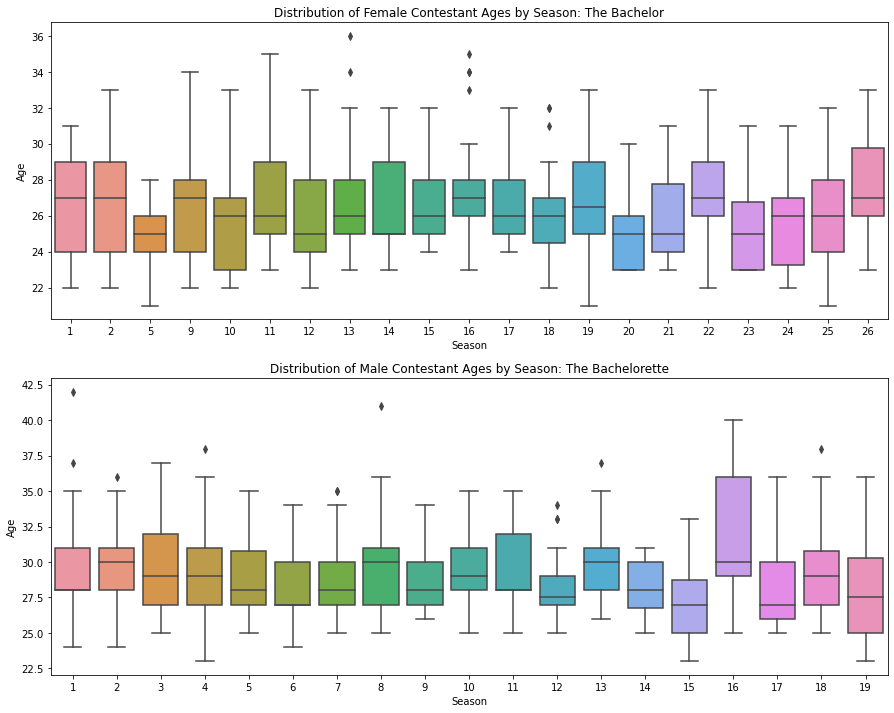

In [200]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 12))

#distribution of ALL Contestant ages by season: Bachelor
sns.boxplot(x='Season', y='Age', data = contestants_df, ax=ax[0])
ax[0].set_title("Distribution of Female Contestant Ages by Season: The Bachelor")

#distribution of ALL Contestant ages by season: Bachelorette
sns.boxplot(x='Season', y='Age', data = contestants_df2, ax=ax[1])
ax[1].set_title("Distribution of Male Contestant Ages by Season: The Bachelorette") 
# show the graph
plt.show()

Now, we will examine how the distribution of contestant ages for all seasons on the Bachelor varies overall, among the top 4 contestants, and among the winners.

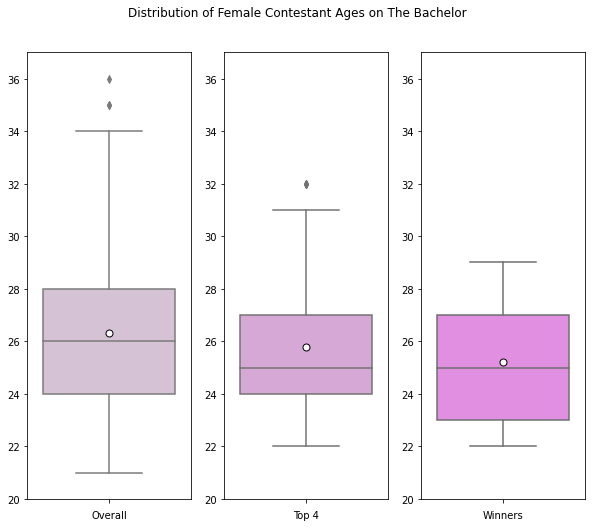

In [201]:
df_list = [contestants_df, top4_df, winners_df]
df_names = ['Overall', 'Top 4', 'Winners']
colors = ['thistle', 'plum', 'violet']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,8))

for c in range(3):
  sns.boxplot(y='Age', data = df_list[c], ax=axes[c], color=colors[c], 
              showmeans = True, meanprops = {'marker': 'o',
                                             'markerfacecolor': 'white',
                                             'markeredgecolor': 'black',
                                             'markersize': 7})
  axes[c].set(ylabel='', xlabel=df_names[c])
  axes[c].set_ylim(20,37)
  axes[c].set_facecolor

fig.subplots_adjust(top=0.9)
fig.suptitle("Distribution of Female Contestant Ages on The Bachelor")
plt.show()

The boxplot demonstrates that the mean age overall is slightly over 26, but for the top 4 and the winners, it slightly decreases to 25, with the winners having the lowest mean age. We see that the variability in age also decreases from overall to top 4 to winners. No woman over 29 has won the show before. This supports our hypothesis that the Bachelors tend to favor younger women, with ages 23-27 being the most popular.

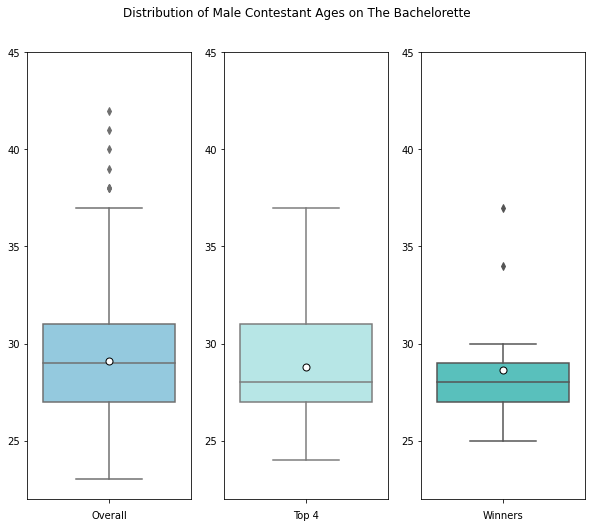

In [202]:
df_list = [contestants_df2, top4_df2, winners_df2]
df_names = ['Overall', 'Top 4', 'Winners']
colors = ['skyblue', 'paleturquoise', 'mediumturquoise']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,8))

for c in range(3):
  sns.boxplot(y='Age', data = df_list[c], ax=axes[c], color=colors[c], 
              showmeans = True, meanprops = {'marker': 'o',
                                             'markerfacecolor': 'white',
                                             'markeredgecolor': 'black',
                                             'markersize': 7})
  axes[c].set(ylabel='', xlabel=df_names[c])
  axes[c].set_ylim(22, 45)
  axes[c].set_facecolor

fig.subplots_adjust(top=0.9)
fig.suptitle("Distribution of Male Contestant Ages on The Bachelorette")
plt.show()

The mean age of male contestants looks to be around 28 overall, among the top 4, and among winners. The distributions of the overall and top 4 groups are quite similar, except for a few outliers in the overall grouping. For winners, the IQR is much smaller. The majority of winners are between ages 27-29. This narrow range of low age values is smaller than we expected; we expected more of the men who won to be in their early thirties.

## Contestants by Occupation

To determine the most common occupations among contestants who win or place in the top 4, we will use a barplot, including the 7 most popular job categories.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


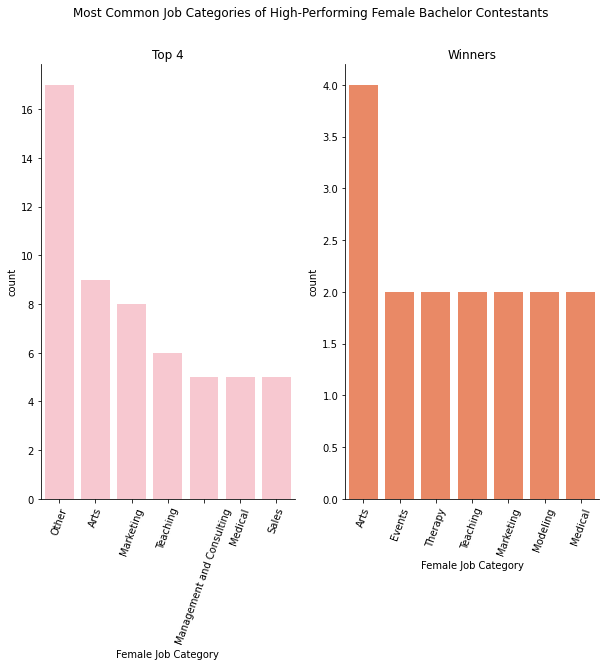

In [291]:
#Job Categories for: Top 4 female contestants AND Winning contestants: The Bachelor
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))

order_top4 = top4_df["Female Job Category"].value_counts().iloc[:7].index
order_winners = winners_df["Female Job Category"].value_counts().iloc[:7].index

sns.countplot(top4_df["Female Job Category"], color="pink", ax = axes[0],
              order=order_top4).set(title="Top 4")
axes[0].set_xticklabels(order_top4, rotation = 70)

sns.countplot(winners_df["Female Job Category"], color="coral", ax = axes[1],
              order=order_winners).set(title="Winners")
axes[1].set_xticklabels(order_winners, rotation = 70)

fig.suptitle('Most Common Job Categories of High-Performing Female Bachelor Contestants')
sns.despine()

Arts is the clear leading category for female winners, with many other categories such as events, therapy, teaching, marketing, modeling, and medicine tied with two wins. Arts, marketing, teaching, and medicine are common among both the top 4 and just winners.

Next, we will do the same for the males.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


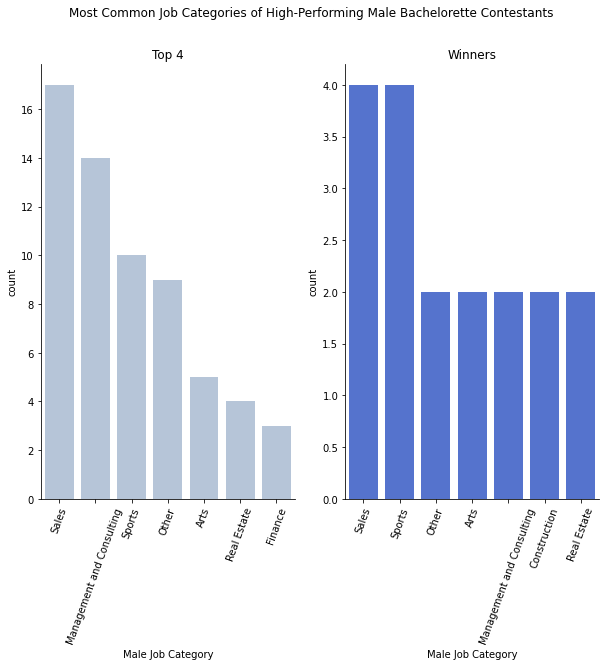

In [292]:
#Job Categories for: Top 4 Male contestants AND Winning Male contestants: The Bachelorette
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))

order_top42 = top4_df2["Male Job Category"].value_counts().iloc[:7].index
order_winners2 = winners_df2["Male Job Category"].value_counts().iloc[:7].index

sns.countplot(top4_df2["Male Job Category"], color="lightsteelblue", ax = axes[0],
              order=order_top42).set(title="Top 4")
axes[0].set_xticklabels(order_top42, rotation = 70)

sns.countplot(winners_df2["Male Job Category"], color="royalblue", ax = axes[1],
              order=order_winners2).set(title="Winners")
axes[1].set_xticklabels(order_winners2, rotation = 70)

fig.suptitle('Most Common Job Categories of High-Performing Male Bachelorette Contestants')
sns.despine()

For males, sales and sports are the most common job categories for winners, each having 4 winners in the respective area. We are not surprised to see these so high. It makes sense that people with the personality of salesmen can push themselves far in the show, and we expect the type of woman going onto the franchise to be interested in athletes.

## Contestants by Home State

# Visualization of Relationship Status

In [258]:
bachelors = {'Season': np.arange(1,27,1),
             'Name': ['Alex Michel', 'Aaron Buerge', 'Andrew Firestone', 
                           'Bob Guiney', 'Jesse Palmer', 'Byron Velvick',
                           "Charlie O'Connell", 'Travis Lane Stork', 'Lorenzo Borghese',
                           'Andy Baldwin', 'Brad Womack', 'Matt Grant',
                           'Jason Mesnick', 'Jake Pavelka', 'Brad Womack',
                           'Ben Flajnik', 'Sean Lowe', 'Juan Pablo Galavis',
                           'Chris Soules', 'Ben Higgins', 'Nick Viall',
                           'Arie Luyendyk Jr.', 'Colton Underwood', 'Peter Weber',
                           'Matt James', 'Clayton Echard'],
                  'Relationship Status': ['Broken Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Together with Runner-Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Together with Winner', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Together with Runner-Up', 'Broken Up', 'Broken Up',
                                          'Together with Winner', 'Broken Up'],
                  'Relationship Length in Years': [8/12, 3/12, 7/12,
                                          1/12, 1/12, 5,
                                          59/12, 1/12, 2/12,
                                          4/12, 0, 2/12,
                                          14, 3/12, 3/12,
                                          7/12, 11, 7/12,
                                          2/12, 14/12, 5/12,
                                          5, 14/12, 0,
                                          2, 6/12],
                  'Height in Inches': [73, 72, 70,
                                       73, 74, 74,
                                       75, 75, 71,
                                       72, 73, 77,
                                       72, 70, 73,
                                       74, 75, 71,
                                       73, 76, 74,
                                       74, 75, 73,
                                       77, 77]}
bachelors_df = pd.DataFrame(bachelors)
bachelors_df.head()

,Season,Name,Relationship Status,Relationship Length in Years,Height in Inches
0,1,Alex Michel,Broken Up,0.666667,73
1,2,Aaron Buerge,Broken Up,0.250000,72
2,3,Andrew Firestone,Broken Up,0.583333,70
3,4,Bob Guiney,Broken Up,0.083333,73
4,5,Jesse Palmer,Broken Up,0.083333,74


In [334]:
!git clone https://github.com/melissamelton/BachelorAnalysis.git

Cloning into 'BachelorAnalysis'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 1.37 MiB | 3.85 MiB/s, done.


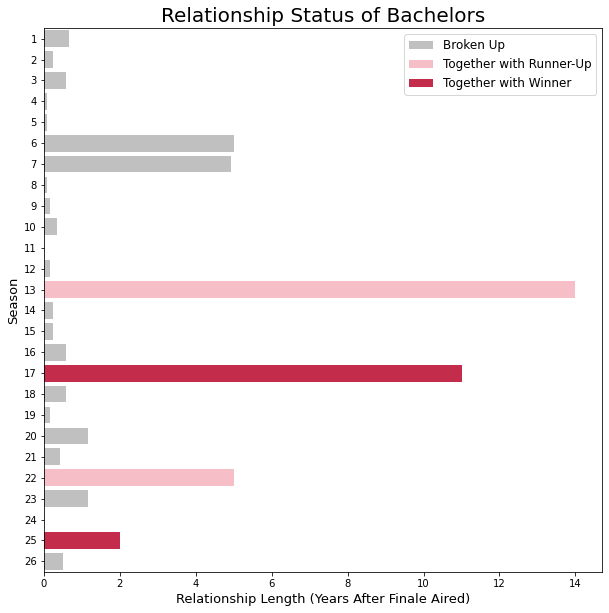

In [347]:
colors = {'Broken Up': 'silver', 
          'Together with Runner-Up': 'lightpink', 
          'Together with Winner': 'crimson'}

plt.figure(figsize = (10,10))
height = 0.9

plt.title('Relationship Status of Bachelors', fontsize = 20)

cur_couples = bachelors_df[bachelors_df['Relationship Status'] != 'Broken Up']

# https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib
'''
for i in range(4):
   image_url = '/content/BachelorAnalysis/' + cur_couples.Name.iloc[i] + '.jpg'
   img = image.imread(image_url)
   rel_len = cur_couples['Relationship Length in Years'].iloc[i]
   szn = cur_couples['Season'].iloc[i]
   plt.imshow(img, extent = [], aspect = 'auto', zorder = 2)
'''
sns.barplot(y = bachelors_df['Season'].apply(str), x = bachelors_df['Relationship Length in Years'],
         hue = bachelors_df['Relationship Status'], palette = colors, dodge = False)

plt.legend(loc = 'upper right', fontsize = 12)
plt.ylabel('Season', fontsize = 13)
plt.xlabel('Relationship Length (Years After Finale Aired)', fontsize = 13)

plt.show()